# CEWA 565
## Homework 5
## Daniel Hogan


**Problem 1: Correlation, Autocorrelation, Multiple Linear Regression
In this problem, you will explore the relationship between air temperature, precipitation, and snow water equivalent over time, using observations from a study site in the Washington Cascades. Download the cascades_swe.xlsx dataset for this problem.**

**A. Begin by making scatterplots of each of these variables vs. all the other variables. Describe any visual patterns you see between each pair of variables.**

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.linalg import lstsq # for the multiple linear regression, we'll use the scipy linear algebra least-squares function
from scipy.interpolate import interp1d # for quantile regression, we'll want this 1d interpolation function
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
df_cascade = pd.read_excel('cascades_swe.xlsx',skiprows=8)
df_cascade = df_cascade.drop(columns=['Unnamed: 0'])
df_cascade = df_cascade.rename(columns={'oct-mar precip':'precip [mm]',
                                        'oct-mar tmax':'Tmax [C]',
                                        'oct-mar tmin':'Tmin [C]',
                                        'April 1 SWE':'April 1 SWE [mm]'})

In [4]:
df_cascade.columns

Index(['Water Year', 'precip [mm]', 'Tmax [C]', 'Tmin [C]',
       'April 1 SWE [mm]'],
      dtype='object')

Text(0.5, 0.98, 'Scatter Matrix for SWE, precipiation, max temperature, and min temperature')

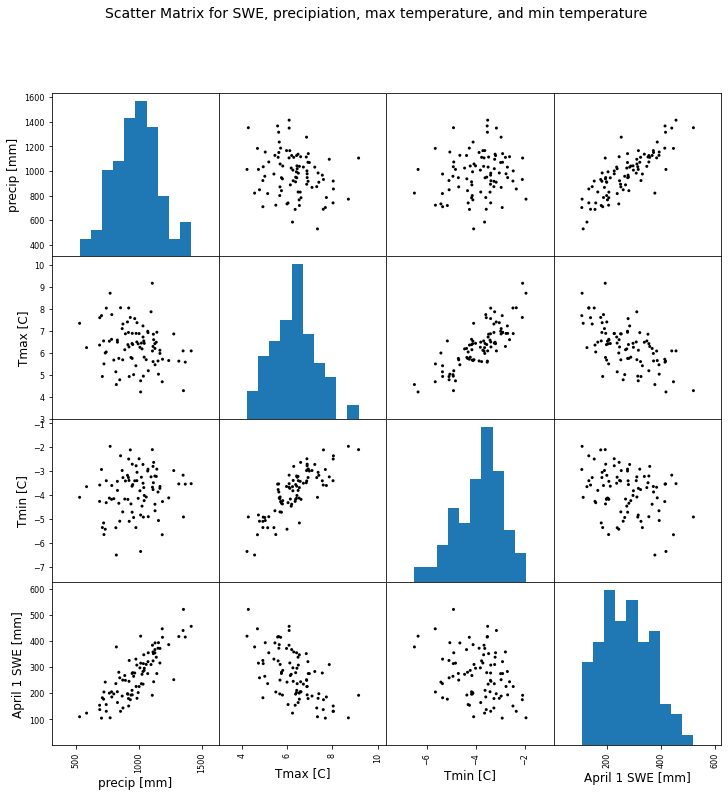

In [5]:
pd.plotting.scatter_matrix(df_cascade.drop(columns='Water Year'), figsize=(12,12), color='k', marker='.', alpha=1, range_padding=0.5)
plt.suptitle('Scatter Matrix for SWE, precipiation, max temperature, and min temperature')

In summary, the relationships I observed are below:
- Precipitation and SWE appear to be correlated, which intuitively makes sense because more precipitation (depending on temperature) should lead to more SWE. 
- SWE and T$_{max}$ appears slightly related where higher temperatures lead to less overall SWE.
- SWE and T$_{min}$ do not appear to have a pattern that is easy to see.
- T$_{max}$ and T$_{min}$ match well, which again makes intuitive sense: a higher max temperature will most likely accompany a higher minimum temperature.
- Precipitation does not match either temperature measurement well.

**B. Calculate the correlation (R) between April 1 SWE and the three meteorological variables (precipitation, maximum temperature, and minimum temperature). Then also calculate R between each unique combination of the meteorological variables. Which meteorological variables seem the most correlated with each other? How might it cause problems if we use both of these in a multi-linear regression?**

In [6]:
# prepare table for R2 values
cols = df_cascade.columns[1:]
r2_vals = pd.DataFrame(columns = cols, index = cols)

In [7]:
# compute R2 values from 
for i,col in enumerate(cols):
    r2 = []
    for i,idx in enumerate(r2_vals.index):
        # use the linear regression function
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_cascade[idx], df_cascade[col])
        # Create points for the regression line
        x = np.linspace(df_cascade[idx].min(), df_cascade[idx].max(), df_cascade[idx].size) # x coordinates from min and max values 
        y = slope * x + intercept # y coordinates using the slope and intercept from our linear regression
        # compute SST for col
        sst_x = np.sum( (df_cascade[idx] - np.mean(df_cascade[idx]))**2 )
        # Compute the standard error
        sigma = stderr * np.sqrt(sst_x)
        r_squared = rvalue
        r2.append(r_squared)
    # output info
    r2_vals.loc[col] = r2
    # conf interval calculations
    sB1 = sigma/np.sqrt(sst_x)

In [8]:
r2_vals

,precip [mm],Tmax [C],Tmin [C],April 1 SWE [mm]
precip [mm],1.0,-0.23464,0.144022,0.811668
Tmax [C],-0.23464,1.0,0.815999,-0.604755
Tmin [C],0.144022,0.815999,1.0,-0.323239
April 1 SWE [mm],0.811668,-0.604755,-0.323239,1.0


In [9]:
print('R-Squared Values:\n',r2_vals,'\n')


R-Squared Values:
                  precip [mm]  Tmax [C]  Tmin [C] April 1 SWE [mm]
precip [mm]              1.0  -0.23464  0.144022         0.811668
Tmax [C]            -0.23464       1.0  0.815999        -0.604755
Tmin [C]            0.144022  0.815999       1.0        -0.323239
April 1 SWE [mm]    0.811668 -0.604755 -0.323239              1.0 



SWE and precipitation, SWE and maximum temperature, and minimum and maximum temperature appear to be the variables best correlated to one another. Minimum and maximum temperature would not be good to use in the model together because issues of multi-collinearity could arise. Multi-collinearity occurs when an explanatory variable is closely related to another explanatory variable (Tmin and Tmax, in this case). Tmin and Tmax are closely related to each other since warmer maximum temperatures tend to correspond to warmer minimum temperatures (and vice-versa), so this could cause issues when attempting to run a MLR.

**C. Calculate the autocorrelation in precipitation, maximum temperature, and minimum temperature over the timeseries. Can we consider each of these values to be an independent sample? Or do some of them depend on the prior year's sample?**

In [10]:
df_cascade = df_cascade.set_index('Water Year')

In [11]:
N = len(df_cascade)
lags = np.arange(0,int(N/4))

In [12]:
df_cascade

,precip [mm],Tmax [C],Tmin [C],April 1 SWE [mm]
Water Year,,,,
1916,1154.570,5.03776,-5.06206,393.719
1917,820.952,4.56727,-6.50644,377.514
1918,1095.650,7.86584,-3.23471,310.131
1919,1041.050,5.80953,-4.22977,287.759
1920,817.106,5.14475,-5.36376,237.118
...,...,...,...,...
1999,1349.600,6.09335,-3.16271,440.455
2000,1071.650,6.92193,-2.91330,321.225
2001,585.318,6.24188,-3.64529,124.212


In [13]:
# adapted from Lab 5-2
# loop through all the lags and compute autocorrelation
variables = ['precip [mm]', 'Tmax [C]', 'Tmin [C]']
auto_corr =  pd.DataFrame(columns=variables)

for var in variables:
    ac = np.empty(len(lags))
    data = df_cascade[var]
    for i, lag in enumerate(lags):
        ac[i] = data.autocorr(lag)
    auto_corr[var] = ac

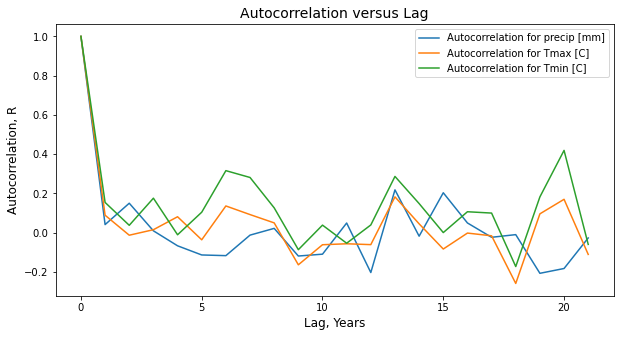

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
for variable in variables:
    ax.plot(lags, auto_corr[variable],'-', label='Autocorrelation for {}'.format(variable))

    ax.set_ylabel('Autocorrelation, R')
    ax.set_xlabel('Lag, Years')
    ax.set_title('Autocorrelation versus Lag')
    ax.set_xticks([0,5,10,15,20])
ax.legend()

As the plot above shows, overall lag-autocorrelation for each variable is small so we can proceed with our tests assuming these variables are each independent samples.

**D. Fit a multiple linear regression model to the data, using only two of the three meteorological variables (precipitation and maximum temperature) to predict April 1 SWE. Report the trend in each meteorological variable. Estimate the overall trend in SWE, and the trend due to each meteorological variable alone. How much of the overall trend is due to the effect of a trend in the maximum temperature? (Note that if we were doing this for research, it would be good to also explore using only minimum temperature, or using the mean daily temperature calculated as (Tmax + Tmin)/2 – however, for simplicity, we will only look a maximum temperature in this problem.)**

Plot up to visualize the data:

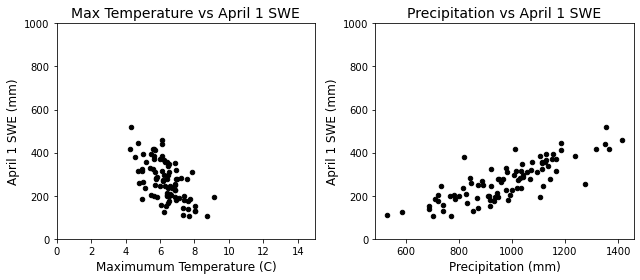

In [15]:
# code adapted from lab 5-1
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(9,4), tight_layout=True)

# Scatterplot of SLI and BLC SWE
df_cascade.plot.scatter(x='Tmax [C]', y='April 1 SWE [mm]', c='k', ax=ax1);
ax1.set_xlabel('Maximumum Temperature (C)')
ax1.set_ylabel('April 1 SWE (mm)')
ax1.set_title('Max Temperature vs April 1 SWE')
ax1.set_xlim((0,15))
ax1.set_ylim((0,1000))

# Scatterplot of Time and BLC SWE
df_cascade.plot.scatter(x='precip [mm]', y='April 1 SWE [mm]', c='k', ax=ax2);
ax2.set_xlabel('Precipitation (mm)')
ax2.set_ylabel('April 1 SWE (mm)')
ax2.set_title('Precipitation vs April 1 SWE')
ax2.set_ylim((0,1000));

In [16]:
# create the input array
multi_input = np.array([ 
                         df_cascade['precip [mm]'], # precipitation
                         df_cascade['Tmax [C]'], # maximum temperature
                         np.ones_like(df_cascade['Tmax [C]']) # array of ones so we allow a constant, y-intercept, value
                       ]).T # Transform this array with ".T" to swap rows and columns

# Show the shapes of our two inputs to the lstsq function to make sure they have the same first dimension length
print(multi_input.shape)
print(df_cascade['April 1 SWE [mm]'].shape)

(88, 3)
(88,)


In [17]:
B, _, _, _ = lstsq(multi_input, df_cascade['April 1 SWE [mm]']) # I'm using "_" as a placeholder for the outputs I don't need
print(B)

[  0.36829552 -42.00738685 174.9906624 ]


These three numbers give our B0, B1, and B2 values:
- B0 value applied to precipitation is $\approx 3.68$
- B1 value applied to maximum temperature is $\approx -42$
- B2 value, the constant offset, is $\approx 174.99$

In [18]:
# Use our linear model to make predictions:
swe_multilinear_model_predictions = multi_input.dot(B)

Let's visualize how the MLR model fits the observed data and plot up some residuals.

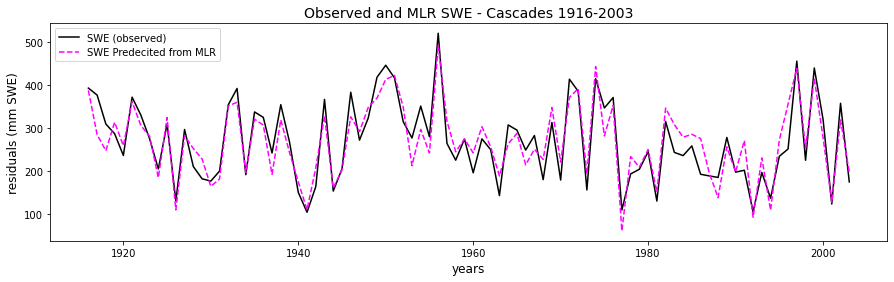

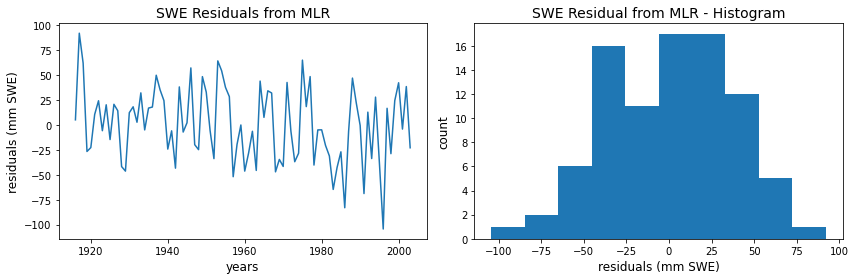

In [19]:
ml_residuals = df_cascade['April 1 SWE [mm]'] - swe_multilinear_model_predictions

f, (ax1) = plt.subplots(1,figsize=(15,4))
f2, (ax2, ax3) = plt.subplots(1,2,figsize=(12,4))
#plot SWE observations
ax1.plot(df_cascade.index,df_cascade['April 1 SWE [mm]'],
        label = 'SWE (observed)',
        color='k')
ax1.set_xlabel('years')
ax1.set_ylabel('residuals (mm SWE)')

# plot MLR predictions
ax1.plot(df_cascade.index,swe_multilinear_model_predictions,
         color='magenta',
         label = 'SWE Predecited from MLR',
         ls='--')
ax1.set_xlabel('years')
ax1.set_ylabel('residuals (mm SWE)')
ax1.set_title('Observed and MLR SWE - Cascades 1916-2003')
ax1.legend()

ax2.plot(df_cascade.index,ml_residuals)
ax2.set_xlabel('years')
ax2.set_ylabel('residuals (mm SWE)')
ax2.set_title('SWE Residuals from MLR')

ax3.hist(ml_residuals)
ax3.set_xlabel('residuals (mm SWE)')
ax3.set_ylabel('count')
ax3.set_title('SWE Residual from MLR - Histogram')

f2.tight_layout()

Now let's figure out what variable has the most influence on SWE in our model.

In [20]:
# precipitation only parameter - dp/dt
# use the linear regression function
B1p, B0, rvalue, pvalue, sB1 = stats.linregress(df_cascade.index, df_cascade['precip [mm]'])
print('d(precipitation)/dt = {}'.format(B1p))          

d(precipitation)/dt = 0.3801062660702335


In [21]:
# temperature only dTmax/dt
# use the linear regression function again
B1T, B0, rvalue, pvalue, sB1 = stats.linregress(df_cascade.index, df_cascade['Tmax [C]'])
print('d(T max)/dt = {}'.format(B1T))          

d(T max)/dt = 0.009144190324398577


In [22]:
# calculate dSWE_MLR/dt from dTmax/dt and dp/dt
dSWE_predicted = B[0]*B1p + B[1]*B1T
print('d(SWE predicted)/dt with MLR = {}'.format(dSWE_predicted)) 

d(SWE predicted)/dt with MLR = -0.24413210478933373


In [23]:
# calculate dSWE_MLR/dt from precipitation
dSWE_p = B[0]*B1p
print('d(SWE predicted)/dt from precipitation = {}'.format(dSWE_p)) 

d(SWE predicted)/dt from precipitation = 0.13999143563435745


In [24]:
# calculate dSWE_MLR/dt from Tmax
dSWE_T = B[1]*B1T
print('d(SWE predicted)/dt from maximum Temperature = {}'.format(dSWE_T)) 

d(SWE predicted)/dt from maximum Temperature = -0.3841235404236912


In [25]:
# calculate dSWE/dt from observed data using linregress
dSWE, B0, rvalue, pvalue, sB1 = stats.linregress(df_cascade.index, df_cascade['April 1 SWE [mm]'])
print('d(SWE observed)/dt = {}'.format(dSWE)) 

d(SWE observed)/dt = -0.5851001285618681


**Portion of model represented by precipitation**

In [31]:
dSWE_p/dSWE_predicted

-0.5734249321905398

**Portion of model represented by maximum temperature**

In [32]:
dSWE_T/dSWE_predicted 

1.5734249321905398

From this quick analysis we found a couple interesting things:
- the MLR predicted trend in SWE was $-0.24$ mm/year, which is quite a bit less than the observed data which found a trend of $-0.585$ mm/year
- the portion of the trend in SWE solely due to precipitation was about $0.14$ mm/year. Precipitation was estimated to have increased with time, but this did not coincide with higher SWE observations, as the observed SWE trend mentioned above was negative. As a result, the ratio of $\frac{d(SWE)}{dt}$ due to precipitation to overall modeled SWE was negative with a value of -0.57. 
- the portion of the trend in SWE solely due to max temperature was about $-0.38$ mm/year. Max temperature was estimated to have grown over this time series as a rate of about $0.01$ C/year. Max temperature appears to be an important metric in estimating SWE relative to precipitation, as it accounts for a large portion of the observed trend in decreasing SWE as shown by the ratio of $\frac{d(SWE)}{dt}$ due to maximum temperature to overall modeled SWE was positive with a value of 1.57.

In [27]:
# Left this in but not really needed
# Use our linear model to make predictions for just precipitation influence:
B1, B0, rvalue, pvalue, sB1 = stats.linregress(df_cascade['precip [mm]'], df_cascade['April 1 SWE [mm]'])
SWE_precip_linear_model = B1 * df_cascade['precip [mm]']+ B0
# Use our linear model to make predictions for just Tmax influence:
B1, B0, rvalue, pvalue, sB1 = stats.linregress(df_cascade['Tmax [C]'], df_cascade['April 1 SWE [mm]'])
SWE_Tmax_linear_model = B1 * df_cascade['Tmax [C]']+ B0

## References
- Lab 5-1: https://mountain-hydrology-research-group.github.io/data-analysis/modules/lab5/lab5-1.ipynb
- Lab 5-2: https://mountain-hydrology-research-group.github.io/data-analysis/modules/lab5/lab5-2.ipynb